In [1]:
import sys 
sys.path.append("..")
from src.dataset import Dataset
import pandas as pd
import os

In [2]:
adult_dataset_generator = Dataset("adult")

In [3]:
protected_attributes = ["sex"]
split_dfs, additional_sizes = adult_dataset_generator.split_population(adult_dataset_generator.original_dataframe, protected_attributes)

print(adult_dataset_generator.original_dataframe)
print(adult_dataset_generator.original_dataframe_encoded)

       age         workclass  fnlwgt   education      marital-status  \
0       39         State-gov   77516   Bachelors       Never-married   
1       50  Self-emp-not-inc   83311   Bachelors  Married-civ-spouse   
2       38           Private  215646     HS-grad            Divorced   
3       53           Private  234721        11th  Married-civ-spouse   
4       28           Private  338409   Bachelors  Married-civ-spouse   
...    ...               ...     ...         ...                 ...   
32556   27           Private  257302  Assoc-acdm  Married-civ-spouse   
32557   40           Private  154374     HS-grad  Married-civ-spouse   
32558   58           Private  151910     HS-grad             Widowed   
32559   22           Private  201490     HS-grad       Never-married   
32560   52      Self-emp-inc  287927     HS-grad  Married-civ-spouse   

              occupation   relationship   race     sex  capital-gain  \
0           Adm-clerical  Not-in-family  White    Male         

In [4]:
print(adult_dataset_generator.original_mappings["race"])

{0: 'Other', 1: 'White'}


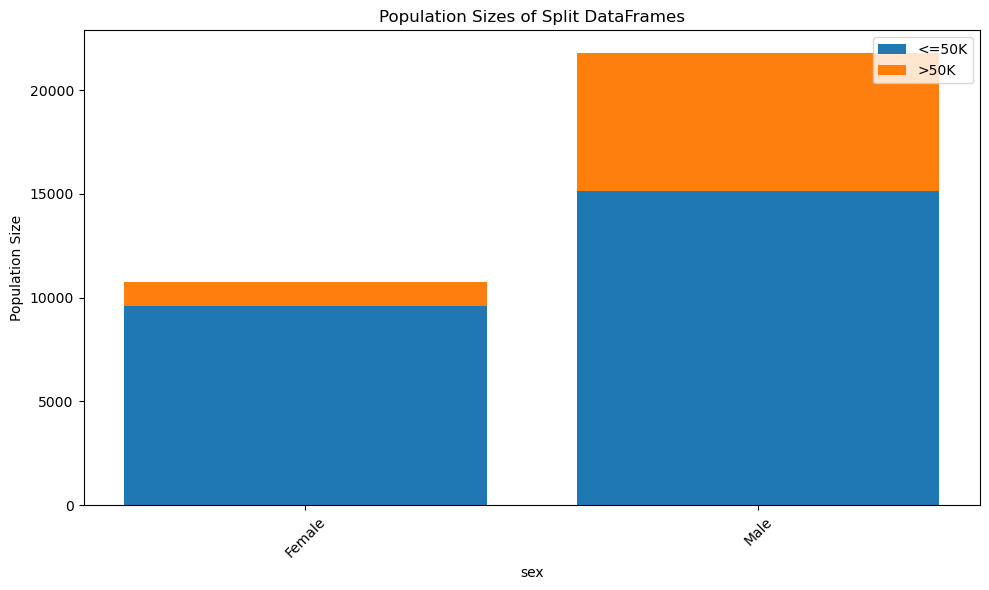

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for income categories
colors = ['#1f77b4', '#ff7f0e']

# Calculate percentages of income categories for each split
income_categories = ['<=50K', '>50K']  # Define the income categories
income_percentages = {}
legend_labels = []
for split_key, split_df in split_dfs.items():
    income_counts = split_df['income'].value_counts(normalize=True) * 100
    income_percentages[split_key] = [income_counts.get(cat, 0) for cat in income_categories]

# Plot population sizes of all split DataFrames along with income category percentages
plt.figure(figsize=(10, 6))
for i, (split_key, split_df) in enumerate(split_dfs.items()):
    population_size = len(split_df)
    income_percentage = income_percentages[split_key]
    bar_positions = np.arange(len(income_percentage))
    # Normalize the heights of the stacked bars
    normalized_heights = np.array(income_percentage) / 100 * population_size
    # Plot stacked bar chart for each split
    plt.bar(split_key, normalized_heights[0], color=colors[0])
    plt.bar(split_key, normalized_heights[1], bottom=normalized_heights[0], color=colors[1])

plt.xlabel(', '.join(protected_attributes))
plt.ylabel('Population Size')
plt.title('Population Sizes of Split DataFrames')
plt.xticks(rotation=45)

# Create a separate legend for income categories
plt.legend(income_categories, loc='upper right')
plt.tight_layout()
plt.show()


In [6]:
# Get the DataFrame with the maximum length
max_length_df_key = max(split_dfs, key=lambda x: len(split_dfs[x]))
print(max_length_df_key)
# Retrieve the DataFrame using the key
max_length_df = split_dfs[max_length_df_key]

max_length_df_class_counts = max_length_df['income'].value_counts()

max_length_df_majority_class = max_length_df_class_counts.idxmax()
max_length_df_majority_class_count = max_length_df_class_counts[max_length_df_majority_class]

target_count_all_protected = 2 * max_length_df_majority_class_count

print(max_length_df_class_counts)

Male
income
<=50K    15128
>50K      6662
Name: count, dtype: int64


In [7]:
# Print split information
for split_key, split_df in split_dfs.items():
    class_counts = split_df['income'].value_counts()
    if len(class_counts) >= 2:  # Check if there are at least two classes
        print(f"For split '{split_key}':")
        for class_label, class_count in class_counts.items():
            minority_class_count = class_count
            imbalance = max_length_df_majority_class_count - minority_class_count
            instances_needed = imbalance 
            total = minority_class_count + instances_needed
            print(f"  Class '{class_label}' has {class_count} instances, and {instances_needed} instances are needed for total to be {total}.")


For split 'Female':
  Class '<=50K' has 9592 instances, and 5536 instances are needed for total to be 15128.
  Class '>50K' has 1179 instances, and 13949 instances are needed for total to be 15128.
For split 'Male':
  Class '<=50K' has 15128 instances, and 0 instances are needed for total to be 15128.
  Class '>50K' has 6662 instances, and 8466 instances are needed for total to be 15128.


In [12]:
augmented_dfs = []
augmented_dfs_plot = []
split_df_keys, split_df_vals = zip(*split_dfs.items())

for split_key, split_df in split_dfs.items():
    class_counts = split_df['income'].value_counts()
    augmented_dfs.append(split_df)

    split_df_plot = split_df.copy()
    split_df_plot["method"] = "real"
    augmented_dfs_plot.append(split_df_plot.copy())

    for class_label, class_count in class_counts.items():
        minority_class_count = class_count
        imbalance = max_length_df_majority_class_count - minority_class_count
        size = imbalance

        if size > 0:
            class_split_df = split_df[split_df['income'] == class_label].copy()
            class_split_df.drop('income', axis=1, inplace=True)
            class_split_df.drop('sex', axis=1, inplace=True)

            split_synthesizer = adult_dataset_generator.train_synthesizer(class_split_df, encode=True) 
            split_synthetic_data = adult_dataset_generator.generate_data(split_synthesizer, num=size)
            split_synthetic_data['income'] = class_label
            split_synthetic_data['sex'] = split_key
            split_synthetic_data_plot = split_synthetic_data.copy()
            split_synthetic_data_plot['method'] = "synthetic"
            augmented_dfs.append(split_synthetic_data.copy())
            augmented_dfs_plot.append(split_synthetic_data_plot.copy())





In [14]:
final_augmented_dataset = pd.concat(augmented_dfs)
final_augmented_dataset_plot = pd.concat(augmented_dfs_plot)
final_augmented_dataset_plot['income_method'] = final_augmented_dataset_plot['income'] + ' (' + final_augmented_dataset_plot['method'] + ')'



/home/luser/miniconda3/envs/samplestructures/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/miniconda3/envs/samplestructures/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/miniconda3/envs/samplestructures/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/miniconda3/envs/samplestructures/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

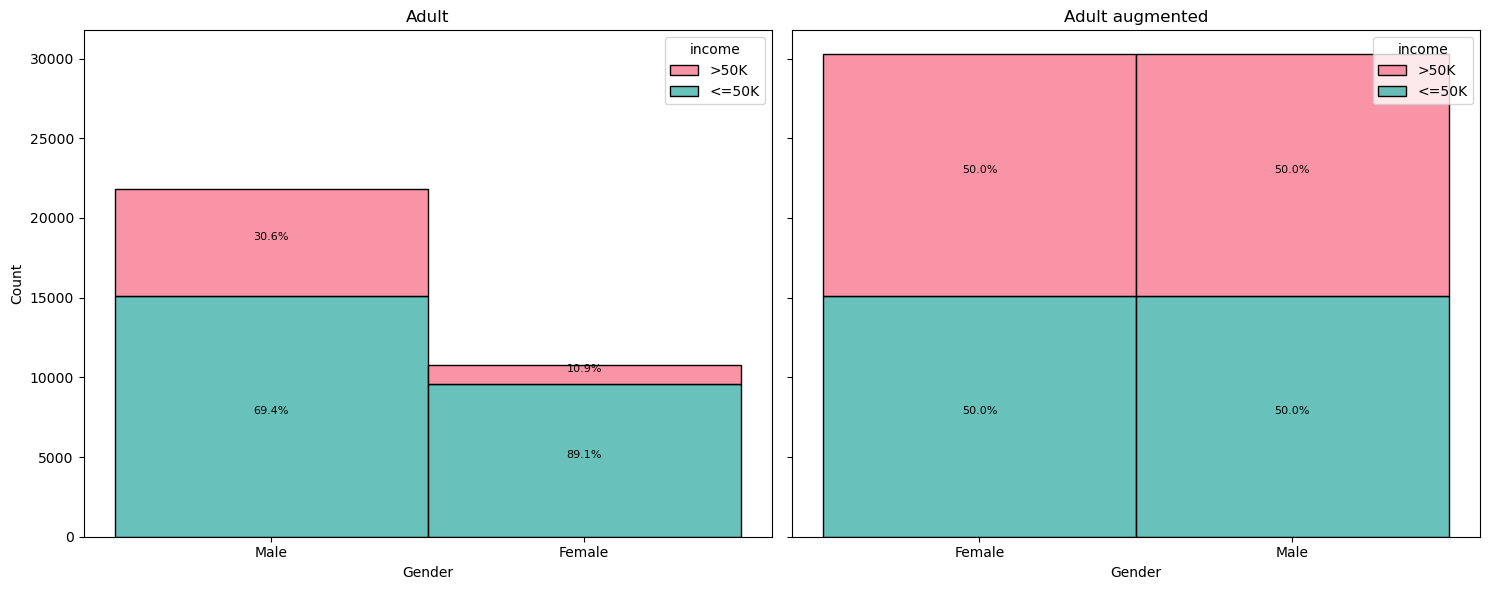

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have two different DataFrames: df1 and df2
# Replace df1 and df2 with your actual DataFrame names

# Set up the plot with two subplots in two columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

# Define the palette using Seaborn's color palette generator
palette = sns.color_palette("husl", 2)  # Using 'husl' palette with 2 colors

gender_order = ['Female', 'Male']  # Adjust as per your actual category order

# Plot for df1
sns.histplot(data=adult_dataset_generator.original_dataframe, x='sex', hue='income', palette=palette, hue_order=['>50K', '<=50K'], multiple="stack", ax=axes[0], discrete = True)
axes[0].set_title('Adult')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')

# Plot for df2
sns.histplot(data=final_augmented_dataset_plot, x='sex', hue='income', palette=palette, hue_order=['>50K', '<=50K'], multiple="stack", ax=axes[1], discrete = True)
axes[1].set_title('Adult augmented')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

for ax in axes:
    for bar in ax.patches:
        # Find the total height of bars for the current x-coordinate
        total_height = sum(p.get_height() for p in ax.patches if p.get_x() == bar.get_x())
        # Calculate the percentage
        percentage = (bar.get_height() / total_height) * 100
        # Annotate the bar with the percentage
        ax.annotate(f'{percentage:.1f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)


plt.show()


In [11]:
final_augmented_dataset.shape

(60512, 14)